In [19]:
from rts.db.dao import DataAccessObject
from rts.db_settings import DATABASE_URL
from rts.db.queries import get_library_id_from_name, read_media_by_source_media_id
from rts.io.media import upload_media_files
from rts.api.models import Media
import os
import hashlib
from rts.db_settings import BUCKET_NAME
from rts.db.queries import create_atlas, create_media, create_projection, read_media
from rts.storage.storage import get_storage_client
from rts.api.models import Atlas, Media, Projection
import pandas as pd
from dotenv import load_dotenv

from sqlalchemy.exc import IntegrityError
import logging

import ffmpeg
from io import BytesIO
from typing import Union, List, Tuple
from pathlib import Path
from datetime import datetime

logging.basicConfig(level=logging.INFO)

load_dotenv()
DataAccessObject().connect(DATABASE_URL)

In [76]:
from tqdm.notebook import trange, tqdm

In [70]:
# Setup before we can create media objects
archive_name =  "ioc"
bucket_name =  archive_name
library_id =  get_library_id_from_name(archive_name)
library_id

3

In [20]:
! ls /media/data/ioc

data  metadata	metadata.zip  videos


In [21]:
! pip install lxml


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [22]:
import os
import pandas as pd

In [23]:
metadata = '/home/andre/rts/metadata.hdf5'

In [3]:
with pd.HDFStore(metadata) as store:
    keys = store.keys()
    print(keys)
    data = store.get(keys[0])  # getting the first dataset

['/df']


In [5]:
data.to_csv('metadata.csv')

In [24]:
df = pd.read_csv('metadata.csv')
data = df

In [25]:
data.head()

,Unnamed: 0,guid,seq_id,date,duration,start,end,description,event,extra,duration_sec,sport,category,raw_round,details,round
0,0,MDA30000800,SEQ30097620,1996-07-30,0 days 00:04:57,19:55:05,20:00:02,START OF TRANSMISSION EVENT: DIVING WOMEN'S 3M...,Diving/Women's 3m Springboard[W]/Preliminary,{},297.0,Diving,Women's 3m Springboard[W],Preliminary,NaN,Preliminary
1,1,MDA30000800,SEQ30097621,1996-07-30,0 days 00:00:07,20:00:02,20:00:09,START: DIVE 1,Diving/Women's 3m Springboard[W]/Preliminary,{},7.0,Diving,Women's 3m Springboard[W],Preliminary,NaN,Preliminary
2,2,MDA30000800,SEQ30097622,1996-07-30,0 days 00:01:42,20:00:09,20:01:51,DIVE: JPN MOTOBUCHI SCORE: 51.12,Diving/Women's 3m Springboard[W]/Preliminary,{},102.0,Diving,Women's 3m Springboard[W],Preliminary,NaN,Preliminary
3,3,MDA30000800,SEQ30097623,1996-07-30,0 days 00:01:04,20:01:51,20:02:55,DIVE: CAN PELLETIER SCORE: 61.38,Diving/Women's 3m Springboard[W]/Preliminary,{},64.0,Diving,Women's 3m Springboard[W],Preliminary,NaN,Preliminary
4,4,MDA30000800,SEQ30097624,1996-07-30,0 days 00:00:58,20:02:55,20:03:53,DIVE: USA MOSES SCORE: 51.03,Diving/Women's 3m Springboard[W]/Preliminary,{},58.0,Diving,Women's 3m Springboard[W],Preliminary,NaN,Preliminary


In [26]:
def find_mp4_files(root_folder):
    mp4_files = []

    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.mp4'):
                mp4_files.append(os.path.join(foldername, filename))

    return mp4_files

In [27]:
mp4_files = find_mp4_files("/media/data/ioc/videos/")
print(f"Found {len(mp4_files)} mp4 files")
print(f"Found {df.guid.nunique()} unique guids")

Found 31304 mp4 files
Found 21712 unique guids


In [28]:
file_map = {}
for mp4 in mp4_files:
    file_map[mp4.split('/')[-1].split('.')[0]] = mp4
mp4_short = [key[4:] for key in file_map.keys()]

In [29]:
guids = set(data['guid'].tolist())
guid_short = [guid[4:] for guid in guids]
len(guids)

21712

In [30]:
# check if guids are in the file map

counter = 0

for key in file_map.keys():
    if key not in guids:
        counter += 1
print(f"Missing {counter} files")

# check the other way around

counter = 0
for guid in guids:
    if guid not in file_map.keys():
        counter += 1
print(f"Missing {counter} guids")



Missing 13527 files
Missing 18486 guids


In [31]:
data[data.guid == list(file_map.keys())[0]]

,Unnamed: 0,guid,seq_id,date,duration,start,end,description,event,extra,duration_sec,sport,category,raw_round,details,round
1991801,2027094,MDA43417188,SEQ43417876,2021-07-26,0 days 02:46:26,20:06:54,22:53:21,"Tokyo 2020 Summer OG, Multi Clip Feeds, Table ...",Table Tennis/Mixed Doubles[X]/Finals,{},9986.0,Table Tennis,Mixed Doubles[X],Finals,NaN,Final


In [32]:
len(set(data.guid.tolist()) & set(file_map.keys()))
print(f"Found {len(set(data.guid.tolist()) & set(file_map.keys()))} matches")

Found 3226 matches


In [33]:
len(set(guid_short) & set(mp4_short))
print(f"Found {len(set(guid_short) & set(mp4_short))} matches")

Found 3226 matches


In [34]:
guid_short[0]

'0020122'

In [35]:
list(set(data.guid.tolist()) & set(file_map.keys()))[:10]

['MDA43014387',
 'MDA42737422',
 'MDA43417806',
 'MDA43312139',
 'MDA43015068',
 'MDA43273360',
 'MDA42918446',
 'MDA42737220',
 'MDA43071835',
 'MDA43339538']

In [36]:
df_seq = data[data.guid.isin(list(set(data.guid.tolist()) & set(file_map.keys())))]

In [37]:
from collections import Counter

In [38]:
guid_counter = Counter()

for guid in data.guid.unique().tolist():
    guid_counter[guid[:4]] += 1

print(f"Most common guids in DataFrame: {guid_counter.most_common(10)}")

file_counter = Counter()

for guid in file_map.keys():
    file_counter[guid[:4]] += 1

print(f"Most common guids for the MP4 Files: {file_counter.most_common(10)}")

Most common guids in DataFrame: [('MDA3', 11791), ('MDA4', 9921)]
Most common guids for the MP4 Files: [('MDA4', 16724), ('MDA3', 18), ('MDA2', 11)]


[('MDA4', 16724), ('MDA3', 18), ('MDA2', 11)]

In [40]:

def trim(input_path: Union[str, Path], start_ts: int, end_ts: int) -> BytesIO:
    try:
        out, _ = (
            ffmpeg
            .input(str(input_path), ss=start_ts)
            .output(
                "pipe:1", 
                format='mp4', 
                vcodec='libx264', 
                acodec='aac', 
                ab='128k',
                t=end_ts - start_ts,
                strict='experimental', 
                movflags='faststart+frag_keyframe+empty_moov'
            )
            .run(capture_stdout=True, capture_stderr=True)
        )
        return BytesIO(out)
    except ffmpeg.Error as e:
        print(f'FFmpeg Error: {e.stderr.decode()}')
    
    return None

In [149]:
df_seq.guid.unique()[:20
]

array(['MDA42998500', 'MDA43015200', 'MDA43017500', 'MDA43032700',
       'MDA43037600', 'MDA43038500', 'MDA43060000', 'MDA43089500',
       'MDA43089600', 'MDA43094600', 'MDA43155300', 'MDA43169600',
       'MDA43214200', 'MDA43221100', 'MDA43225400', 'MDA43292400',
       'MDA43296000', 'MDA43312900', 'MDA43328900', 'MDA43339200'],
      dtype=object)

In [152]:
clip = df_seq.iloc[0].to_dict()

In [153]:
df_norm = df_seq[df_seq.guid == 'MDA43169600']
df_norm.shape

(386, 16)

In [154]:
df_norm.head()

,Unnamed: 0,guid,seq_id,date,duration,start,end,description,event,extra,duration_sec,sport,category,raw_round,details,round
19714,20224,MDA43169600,SEQ43195661,2021-07-28,0 days 00:00:27,13:30:36,13:31:04,Basketball ; Men's Preliminary Round Group A ;...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},27.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary
19715,20225,MDA43169600,SEQ43195662,2021-07-28,0 days 00:00:09,13:31:04,13:31:14,Basketball ; Men's ; Preliminary Round Group A...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},9.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary
19716,20226,MDA43169600,SEQ43195663,2021-07-28,0 days 00:00:07,13:31:14,13:31:21,Basketball ; Men's ; Preliminary Round Group A...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},7.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary
19717,20227,MDA43169600,SEQ43195664,2021-07-28,0 days 00:00:42,13:31:21,13:32:04,Basketball ; Men's ; Preliminary Round Group A...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},42.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary
19718,20228,MDA43169600,SEQ43195665,2021-07-28,0 days 00:00:06,13:32:04,13:32:10,Basketball ; Men's ; Preliminary Round Group A...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},6.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary


In [155]:
# Normalize the timestamps for the clips

df_norm.loc[:, 'start_ts'] = df_norm.start.apply(lambda x: (datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds())
df_norm.loc[:, 'end_ts'] = df_norm.end.apply(lambda x: (datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds())
df_norm.loc[:, 'end_ts'] = df_norm.end_ts - df_norm.start_ts.min()
df_norm.loc[:, 'start_ts'] = df_norm.start_ts - df_norm.start_ts.min()

/tmp/ipykernel_41647/4058683711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm.loc[:, 'start_ts'] = df_norm.start.apply(lambda x: (datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds())
/tmp/ipykernel_41647/4058683711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm.loc[:, 'end_ts'] = df_norm.end.apply(lambda x: (datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds())


In [156]:
i = 0

clip_path = file_map[df_norm.guid.iloc[i]]
start = df_norm.start_ts.iloc[i]
end = df_norm.end_ts.iloc[i]
print(f"Trimming {clip_path} from {start} to {end}")
# buffer = trim(file_map[clip['guid']], start, end)

Trimming /media/data/ioc/videos/0/0/MDA43169600/MDA43169600.mp4 from 0.0 to 28.0


In [157]:
row = df_norm.iloc[i]

In [158]:
file_map[row.guid]

'/media/data/ioc/videos/0/0/MDA43169600/MDA43169600.mp4'

In [159]:
def get_frame_rate(input_path: Union[str, Path]) -> float:
    probe = ffmpeg.probe(str(input_path))
    video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
    if video_stream is None:
        return None
    
    r_frame_rate = video_stream['r_frame_rate']
    num, den = map(int, r_frame_rate.split('/'))
    return num / den

In [165]:
df.seq_id.nunique()

2244619

In [166]:
df.shape

(2244620, 16)

In [160]:
row

Unnamed: 0                                                  20224
guid                                                  MDA43169600
seq_id                                                SEQ43195661
date                                                   2021-07-28
duration                                          0 days 00:00:27
start                                                    13:30:36
end                                                      13:31:04
description     Basketball ; Men's Preliminary Round Group A ;...
event           Basketball/Men[M]/Preliminary Round Group A/Pr...
extra                                                          {}
duration_sec                                                 27.0
sport                                                  Basketball
category                                                   Men[M]
raw_round                               Preliminary Round Group A
details                                 Preliminary Round Group A
round     

In [161]:
frame_rates = {}
clips = {}
media_ids = {}

for i, row in df_norm.iterrows():

    media_id = row.guid + "IOC" + str(i).zfill(5)
    original_path = file_map[row.guid]
    media_path = f"videos/{row.guid}/{media_id}.mp4"
    
    if frame_rates.get(original_path) is None:
        frame_rates[original_path] = get_frame_rate(original_path)

    metadata = {
        'sport': row.sport,
        'description': row.description,
        'event': row.event,
        'category': row.category,
        'round': row['round'],
        'raw_round': row.raw_round,
    }

    media_ids[media_id] = row
    
    clips[media_id] = Media(**{
        'media_id': row.seq_id,
        'original_path': original_path,
        'original_id': row.guid,
        'media_path': media_path, 
        'media_type': "video",
        'sub_type': "clip", 
        'size': -1, # write size later when we process the clips 
        'metadata': metadata,
        'library_id': library_id, 
        'hash': hashlib.md5(media_path.encode()).hexdigest(), 
        'parent_id': -1,
        'start_ts': row.start_ts, 'end_ts': row.end_ts, 
        'start_frame': row.start_ts * frame_rates[original_path], 'end_frame': row.end_ts * frame_rates[original_path], 'frame_rate': frame_rates[original_path], 
    })

In [167]:
row.seq_id

'SEQ43196046'

In [162]:
clips.keys()

dict_keys(['MDA43169600IOC19714', 'MDA43169600IOC19715', 'MDA43169600IOC19716', 'MDA43169600IOC19717', 'MDA43169600IOC19718', 'MDA43169600IOC19719', 'MDA43169600IOC19720', 'MDA43169600IOC19721', 'MDA43169600IOC19722', 'MDA43169600IOC19723', 'MDA43169600IOC19724', 'MDA43169600IOC19725', 'MDA43169600IOC19726', 'MDA43169600IOC19727', 'MDA43169600IOC19728', 'MDA43169600IOC19729', 'MDA43169600IOC19730', 'MDA43169600IOC19731', 'MDA43169600IOC19732', 'MDA43169600IOC19733', 'MDA43169600IOC19734', 'MDA43169600IOC19735', 'MDA43169600IOC19736', 'MDA43169600IOC19737', 'MDA43169600IOC19738', 'MDA43169600IOC19739', 'MDA43169600IOC19740', 'MDA43169600IOC19741', 'MDA43169600IOC19742', 'MDA43169600IOC19743', 'MDA43169600IOC19744', 'MDA43169600IOC19745', 'MDA43169600IOC19746', 'MDA43169600IOC19747', 'MDA43169600IOC19748', 'MDA43169600IOC19749', 'MDA43169600IOC19750', 'MDA43169600IOC19751', 'MDA43169600IOC19752', 'MDA43169600IOC19753', 'MDA43169600IOC19754', 'MDA43169600IOC19755', 'MDA43169600IOC19756', 

In [ ]:
for key in tqdm(media_ids):
    # if media_ids[key].scenes_tc[1] - media_ids[key].scenes_tc[0] < 4:
    #     continue

    try:
        print(clips[key].original_path, media_ids[key].start_ts, media_ids[key].end_ts)
        buffer = trim(clips[key].original_path, media_ids[key].start_ts, media_ids[key].end_ts)
        clips[key].size = len(buffer.getvalue())
        get_storage_client().upload_binary(bucket_name, clips[key].media_path, buffer)
        create_media(clips[key])
    except IntegrityError as e:
        if "duplicate key value violates unique constraint" in str(e):
            pass
            # logging.info(f'UniqueViolation: Duplicate media_id {clips[key].media_id}')
        else:
            raise e


In [71]:

buffer = trim(file_map[clip['guid']], start, end)

In [68]:
with open('test.mp4', 'wb') as f:
    f.write(buffer.read())

In [170]:
def calculate_difference(row):
    return row['end_ts'] - row['start_ts']

df_norm['difference'] = df_norm.apply(calculate_difference, axis=1)

/tmp/ipykernel_41647/2917326498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm['difference'] = df_norm.apply(calculate_difference, axis=1)


In [171]:
df_norm.head()

,Unnamed: 0,guid,seq_id,date,duration,start,end,description,event,extra,duration_sec,sport,category,raw_round,details,round,start_ts,end_ts,difference
19714,20224,MDA43169600,SEQ43195661,2021-07-28,0 days 00:00:27,13:30:36,13:31:04,Basketball ; Men's Preliminary Round Group A ;...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},27.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary,0.0,28.0,28.0
19715,20225,MDA43169600,SEQ43195662,2021-07-28,0 days 00:00:09,13:31:04,13:31:14,Basketball ; Men's ; Preliminary Round Group A...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},9.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary,28.0,38.0,10.0
19716,20226,MDA43169600,SEQ43195663,2021-07-28,0 days 00:00:07,13:31:14,13:31:21,Basketball ; Men's ; Preliminary Round Group A...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},7.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary,38.0,45.0,7.0
19717,20227,MDA43169600,SEQ43195664,2021-07-28,0 days 00:00:42,13:31:21,13:32:04,Basketball ; Men's ; Preliminary Round Group A...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},42.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary,45.0,88.0,43.0
19718,20228,MDA43169600,SEQ43195665,2021-07-28,0 days 00:00:06,13:32:04,13:32:10,Basketball ; Men's ; Preliminary Round Group A...,Basketball/Men[M]/Preliminary Round Group A/Pr...,{},6.0,Basketball,Men[M],Preliminary Round Group A,Preliminary Round Group A,Preliminary,88.0,94.0,6.0


<Axes: >

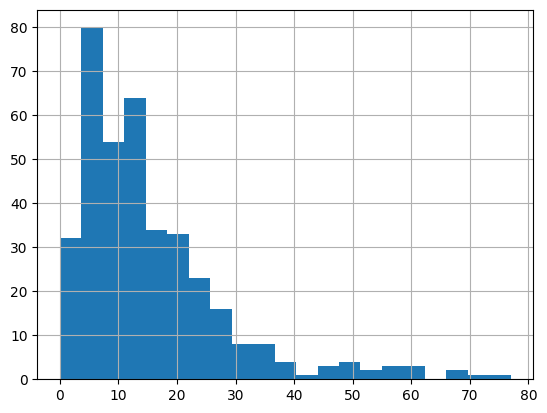

In [172]:
df_norm[df_norm.difference < 80].difference.hist(bins=21)

In [173]:
df_norm.difference.describe()

count    386.000000
mean      18.370466
std       27.199600
min        0.000000
25%        7.000000
50%       12.000000
75%       21.000000
max      419.000000
Name: difference, dtype: float64

In [ ]:
list(df_norm.sort_values('difference', ascending=True).head(10)[['guid', 'difference', 'description']].values)

In [169]:

for i, row in df_norm.iterrows():
    print(i, row.guid, row.difference, row.description)

AttributeError: 'Series' object has no attribute 'difference'

In [122]:
df_norm

,Unnamed: 0,guid,seq_id,date,duration,start,end,description,event,extra,duration_sec,sport,category,raw_round,details,round,start_ts,end_ts,difference
16300,16800,MDA42998500,SEQ43010335,2021-08-02,0 days 00:00:29,08:50:33,08:51:02,Volleyball ; Women's Preliminary Round - Pool ...,Volleyball/Women[W]/Preliminary Round,{},29.0,Volleyball,Women[W],Preliminary Round,NaN,Preliminary,0.0,29.0,29.0
16301,16801,MDA42998500,SEQ43010337,2021-08-02,0 days 00:00:29,08:51:02,08:51:32,Volleyball ; Women's ; Women's Preliminary Rou...,Volleyball/Women[W]/Preliminary Round,{},29.0,Volleyball,Women[W],Preliminary Round,NaN,Preliminary,29.0,59.0,30.0
16302,16802,MDA42998500,SEQ43010339,2021-08-02,0 days 00:00:30,08:51:32,08:52:02,Volleyball ; Women's ; Preliminary Round Pool ...,Volleyball/Women[W]/Preliminary Round,{},30.0,Volleyball,Women[W],Preliminary Round,NaN,Preliminary,59.0,89.0,30.0
16303,16803,MDA42998500,SEQ43010341,2021-08-02,0 days 00:00:16,08:52:02,08:52:19,Volleyball ; Women's ; Preliminary Round Pool ...,Volleyball/Women[W]/Preliminary Round,{},16.0,Volleyball,Women[W],Preliminary Round,NaN,Preliminary,89.0,106.0,17.0
16304,16804,MDA42998500,SEQ43010343,2021-08-02,0 days 00:00:13,08:52:19,08:52:32,Volleyball ; Women's ; Preliminary Round Pool ...,Volleyball/Women[W]/Preliminary Round,{},13.0,Volleyball,Women[W],Preliminary Round,NaN,Preliminary,106.0,119.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16801,17301,MDA42998500,SEQ43011555,2021-08-02,0 days 00:00:02,10:24:51,10:24:54,Volleyball ; Women's ; Preliminary Round Pool ...,Volleyball/Women[W]/Preliminary Round,{},2.0,Volleyball,Women[W],Preliminary Round,NaN,Preliminary,5658.0,5661.0,3.0
16802,17302,MDA42998500,SEQ43011558,2021-08-02,0 days 00:00:01,10:24:54,10:24:55,Volleyball ; Women's ; Preliminary Round Pool ...,Volleyball/Women[W]/Preliminary Round,{},1.0,Volleyball,Women[W],Preliminary Round,NaN,Preliminary,5661.0,5662.0,1.0
16803,17303,MDA42998500,SEQ43011562,2021-08-02,0 days 00:00:06,10:24:55,10:25:01,Volleyball ; Women's ; Preliminary Round Pool ...,Volleyball/Women[W]/Preliminary Round,{},6.0,Volleyball,Women[W],Preliminary Round,NaN,Preliminary,5662.0,5668.0,6.0
16804,17304,MDA42998500,SEQ43011565,2021-08-02,0 days 00:00:50,10:25:01,10:25:52,Volleyball ; Women's ; Preliminary Round Pool ...,Volleyball/Women[W]/Preliminary Round,{},50.0,Volleyball,Women[W],Preliminary Round,NaN,Preliminary,5668.0,5719.0,51.0
